In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import glob
import os

In [2]:
# construct big classification
big_class = {}
big_class['multiple_object'] = ['EllipVar', 'Symbiotic*','SB*','DQHer', 
                                'Nova-like','EB*betLyr','AMHer','Nova','EB*Algol',
                                'EB*WUMa','CataclyV*',
                                  'DwarfNova','EB*']
big_class['star'] = ['brownD*','SG*','RCrB_Candidate', 'HV*', 'WR*', 'YellowSG*','gammaDor','RotV*alf2CVn',
                     'Erupt*RCrB','BlueStraggler','Eruptive*','V*?', 'Pulsar', 
                     'PulsV*bCep','low-mass*','post-AGB*', 'Pec*','pMS*','HotSubdwarf',
                     'PM*','*inNeb','pulsV*SX','RGB*','HB*','BYDra',
                       'PulsV*RVTau', 'BlueSG*','Irregular_V*','WD*','Ae*','RedSG*',
                     'AGB*','OH/IR','Be*','Cepheid','PulsV*delSct','RotV*','PulsV*',
                       'PulsV*WVir','S*','RSCVn','deltaCep','TTau*','Em*','Orion_V*',
                     'YSO','V*','C*','Mira','LPV*','Star','RRLyr']
big_class['AGN-like'] = ['LINER','Blazar','AGN','BLLac','QSO','Galaxy']
big_class['other_SN'] = ['SNIb-pec', 'SNIb/c','SNII-pec','SN', 'SNIbn','SNIc-BL','SNI',
                   'SNIb','SNIIb','SLSN-II','SNIIP','SLSN-I','SNIc','SNIIn','SNII',
                  'SN Ibn','SN Ic-BL','SN I', 'SN Ib','SN IIb','SN IIP', 'SN Ic','SN IIn',
                   'SN II', 'SN Icn', 'SNIcn', 'SN Ib/c','SN Ib-pec','SN IIL', 'SN II-pec']
big_class['other_TNS'] = ['Mdwarf', 'LBV','TDE','Other','CV','Varstar', 'M dwarf','LRN',
                          'FRB']
big_class['SNIa'] = ['Ia', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 
                'SN Ia-pec', 'SN Iax[02cx-like]']

# reverse it
class_dict = {}
for key in big_class.keys():
    for item in big_class[key]:
        class_dict[item] = key

# Full initial data set (all available labels from SIMBAD and TNS)

In [3]:
# this folder is avaliable through zenodo: 
# https://zenodo.org/record/5645609#.Yc5SpXXMJNg
dirname_input = '../../../../data/AL_data/'
flist = os.listdir(dirname_input)

In [4]:
simbad_alerts = []
tns_alerts = []
tns_classes = []
simbad_objects = []
tns_objects = []
simbad_classes = []

# read all tns file and n_files_simbad random simbad file
for name in flist:
    if 'simbad' in name:
        d1 = pd.read_parquet(dirname_input + name)
        simbad_alerts.append(d1.shape[0])
        nobjs = np.unique(d1['objectId'].values).shape[0]
        simbad_objects.append(nobjs)
        d2 = d1.drop_duplicates(subset=['objectId'], keep='first')
        simbad_classes = simbad_classes + list(d2['cdsxmatch'].values)
    elif 'tns' in name:
        d1 = pd.read_parquet(dirname_input + name)
        tns_alerts.append(d1.shape[0])
        nobjs = np.unique(d1['objectId'].values).shape[0]
        tns_objects.append(nobjs)
        d2 = d1.drop_duplicates(subset=['objectId'], keep='first')
        tns_classes = tns_classes + list(d2['TNS'].values)

In [5]:
# number of alerts with SIMBAD classification
sum(simbad_alerts)

5004378

In [6]:
# number of objects with SIMBAD classification
len(simbad_classes)

1313371

In [7]:
# check classes of all SIMBAD objects
simbad_orig_classes, simbad_orig_numbers = \
    np.unique(simbad_classes, return_counts=True)

simbad_orig_classes_perc = 100*np.round(simbad_orig_numbers/len(simbad_classes), 4)


df_simbad_orig = pd.DataFrame(np.array([simbad_orig_classes, 
                               simbad_orig_numbers,
                               simbad_orig_classes_perc]).transpose(), 
                              columns=['class', 'number', 'perc'])

In [8]:
df_simbad_orig.to_csv('../../../../referee/data/simbad_orig_classes.csv', 
                      index=False)

In [9]:
# number of alerts with TNS classification
sum(tns_alerts)

11422

In [10]:
# number of objects with TNS classification
sum(tns_objects)

11329

In [11]:
# check classes of all TNS objects
tns_orig_classes, tns_orig_numbers = \
    np.unique(tns_classes, return_counts=True)

tns_orig_classes_perc = 100*np.round(tns_orig_numbers/len(tns_classes), 4)


df_tns_orig = pd.DataFrame(np.array([tns_orig_classes, 
                               tns_orig_numbers,
                               tns_orig_classes_perc]).transpose(), 
                              columns=['class', 'number', 'perc'])

In [12]:
df_tns_orig.to_csv('../../../../referee/data/tns_orig_classes.csv', 
                  index=False)

# Raw vs feature extraction

In [13]:
fname = '../../../../referee/data/raw.csv.gz'
data = pd.read_csv(fname)

In [14]:
data.shape

(86422, 10)

In [15]:
data.shape[0] - sum(tns_alerts)

75000

In [16]:
np.unique(data['objectId'].values).shape

(52405,)

In [17]:
np.unique(data['objectId'].values).shape[0] - sum(tns_objects)

41076

In [18]:
data_raw = []
galaxy = []
other_sn = []
mult = []
other_tns = []
snia = []

for i in range(data.shape[0]):
    
    objtype = data.iloc[i]['TNS']
    if objtype == '-99':
        objtype = data.iloc[i]['cdsxmatch']

    data_raw.append(class_dict[objtype])
    
    big = class_dict[objtype]
    if  big == 'AGN-like':
        galaxy.append(objtype)
    if big == 'other_SN':
        other_sn.append(objtype)
    if big == 'multiple_object':
        mult.append(objtype)
    if big == 'other_TNS':
        other_tns.append(objtype)
    if big == 'SNIa':
        snia.append([objtype, data.iloc[i]['objectId']])
    
data_raw = np.array(data_raw)
galaxy = np.array(galaxy)
other_tns = np.array(other_tns)
mult = np.array(mult)
snia = np.array(snia)

In [19]:
np.unique(snia[:,1]).shape

(2287,)

In [20]:
sntype, freq = np.unique(galaxy, return_counts=True)

print('Galaxy-sub-type  ---  number')
for i in range(len(sntype)):
    print(sntype[i], '  --  ', freq[i])

Galaxy-sub-type  ---  number
AGN   --   414
BLLac   --   607
Blazar   --   14
Galaxy   --   5
LINER   --   3
QSO   --   5634


In [21]:
sntype, freq = np.unique(other_sn, return_counts=True)
print('SN-sub-type  ---  number')
for i in range(len(sntype)):
    print(sntype[i], '  --  ', freq[i])

SN-sub-type  ---  number
SLSN-I   --   200
SLSN-II   --   145
SN   --   26
SN I   --   53
SN II   --   1969
SN II-pec   --   6
SN IIL   --   1
SN IIP   --   293
SN IIb   --   101
SN IIn   --   523
SN Ib   --   167
SN Ib-pec   --   5
SN Ib/c   --   22
SN Ibn   --   28
SN Ic   --   266
SN Ic-BL   --   84
SN Icn   --   2


In [22]:
sntype, freq = np.unique(other_tns, return_counts=True)

print('Other TNS-sub-type  ---  number')
for i in range(len(sntype)):
    print(sntype[i], '  --  ', freq[i])

Other TNS-sub-type  ---  number
CV   --   400
FRB   --   7
LBV   --   24
LRN   --   3
M dwarf   --   45
Other   --   107
TDE   --   88
Varstar   --   290


In [23]:
sntype, freq = np.unique(mult, return_counts=True)

print('Multiple object-sub-type  ---  number')
for i in range(len(sntype)):
    print(sntype[i], '  --  ', freq[i])

Multiple object-sub-type  ---  number
AMHer   --   46
CataclyV*   --   370
DQHer   --   20
DwarfNova   --   264
EB*   --   15204
EB*Algol   --   571
EB*WUMa   --   237
EB*betLyr   --   162
EllipVar   --   21
Nova   --   118
Nova-like   --   29
SB*   --   20
Symbiotic*   --   21


In [24]:
features = pd.read_csv('../../../../referee/data/features.csv', index_col=False)

features_class = []

for i in range(features.shape[0]):
    
    objtype = features.iloc[i]['type']
    features_class.append(class_dict[objtype])
            
features_class = np.array(features_class)

In [25]:
objId = []

for i in range(features.shape[0]):
    candid = features.iloc[i]['id']
    indx = list(data['candid'].values).index(candid)
    objId.append([data.iloc[indx]['objectId'],data.iloc[indx]['TNS']])

In [26]:
len(objId)

23775

In [27]:
np.unique(np.array(objId)[:,0]).shape

(15751,)

In [28]:
Ia_flag = np.array([item in big_class['SNIa'] for item in np.array(objId)[:,1]])

In [29]:
Ia_id = np.array(objId)[Ia_flag]

In [30]:
np.unique(Ia_id[:,0]).shape

(1021,)

In [31]:
types_raw, number_raw = np.unique(data_raw, return_counts=True)
types_features, number_features = np.unique(features_class, return_counts=True)

raw_pop = pd.DataFrame()
raw_pop['type'] = types_raw
raw_pop['sample fraction'] = number_raw.astype(float)/len(data_raw)
raw_pop['number'] = number_raw
raw_pop['sample'] = 'raw'

c1 = pd.DataFrame()
c1['type'] = np.unique(features_class, return_counts=True)[0]
c1['sample fraction'] = np.unique(features_class, return_counts=True)[1]/len(features_class)
c1['sample'] = 'after feature extraction'
c1['number'] = np.unique(features_class, return_counts=True)[1]

pop = pd.concat([raw_pop,c1], ignore_index=True)

In [32]:
pop

,type,sample fraction,number,sample
0,AGN-like,0.077260,6677,raw
1,SNIa,0.072539,6269,raw
2,multiple_object,0.197670,17083,raw
3,other_SN,0.045023,3891,raw
4,other_TNS,0.011155,964,raw
5,star,0.596353,51538,raw
6,AGN-like,0.124543,2961,after feature extraction
7,SNIa,0.067298,1600,after feature extraction
8,multiple_object,0.185868,4419,after feature extraction
9,other_SN,0.032050,762,after feature extraction


In [33]:
sum(pop['number'][pop['sample'] == 'after feature extraction'])

23775

In [34]:
sum(pop['number'][pop['sample'] == 'raw'])

86422

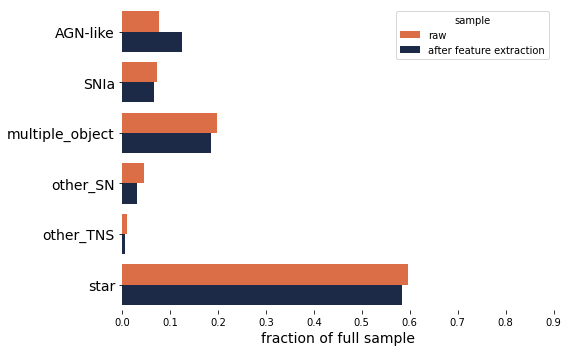

In [35]:
c = ['#F5622E', '#15284F']

f, ax = plt.subplots(figsize=(8, 5))

sns.set_palette('Spectral')
sns.barplot(x="sample fraction", y="type", data=pop,
            hue='sample', ci=None, palette=c)
ax.set(xlim=(0, 0.9), ylabel="")
ax.set_xlabel(xlabel="fraction of full sample", fontsize=14)
ax.set_yticklabels(types_raw, fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
#plt.show()
plt.savefig('../../../../referee/plots/perc_raw_features.pdf')

In [36]:
pop

,type,sample fraction,number,sample
0,AGN-like,0.077260,6677,raw
1,SNIa,0.072539,6269,raw
2,multiple_object,0.197670,17083,raw
3,other_SN,0.045023,3891,raw
4,other_TNS,0.011155,964,raw
5,star,0.596353,51538,raw
6,AGN-like,0.124543,2961,after feature extraction
7,SNIa,0.067298,1600,after feature extraction
8,multiple_object,0.185868,4419,after feature extraction
9,other_SN,0.032050,762,after feature extraction


# Queried sample

In [37]:
res_queried = {}

for strategy in ['RandomSampling', 'UncSampling']:
    flist = glob.glob('../../../../referee/' + strategy + '/queries/queried_' + strategy + '_v*.dat')

    res_queried[strategy] = {}
    for name in big_class.keys():
        res_queried[strategy][name] = []

    for j in range(len(flist)):
        data = pd.read_csv(flist[j], delim_whitespace=True, index_col=False)
        data_class = np.array([class_dict[item] for item in data['type'].values])
        sntype, freq = np.unique(data_class, return_counts=True)

        for i in range(len(freq)):
            res_queried[strategy][sntype[i]].append(freq[i]/data.shape[0])


In [38]:
for strategy in ['RandomSampling', 'UncSampling']:
    
    print('**** ' + strategy + ' ****')
    for key in res_queried[strategy].keys():
        print(key, ' -- ', np.round(100* np.mean(res_queried[strategy][key]), 2), 
              ' -- ', np.round(100*np.std(res_queried[strategy][key]),2))
        
    print('\n')

**** RandomSampling ****
multiple_object  --  18.84  --  2.35
star  --  58.52  --  2.89
AGN-like  --  12.15  --  1.95
other_SN  --  3.17  --  0.93
other_TNS  --  0.82  --  0.46
SNIa  --  6.58  --  1.28


**** UncSampling ****
multiple_object  --  6.31  --  1.28
star  --  21.58  --  2.04
AGN-like  --  9.82  --  1.95
other_SN  --  16.76  --  1.7
other_TNS  --  0.78  --  0.36
SNIa  --  44.8  --  1.4




In [56]:
df1 = pd.DataFrame()
df1['type'] = res_queried['RandomSampling'].keys()
df1['sample fraction'] = [np.mean(res_queried['RandomSampling'][key])
                         for key in res_queried['RandomSampling'].keys()]
df1['strategy'] = 'RandomSampling'

df2 = pd.DataFrame()
df2['type'] =  res_queried['UncSampling'].keys()
df2['sample fraction'] = [np.mean(res_queried['UncSampling'][key])
                         for key in res_queried['UncSampling'].keys()]
df2['strategy'] = 'UncSampling'

df = pd.concat([df2, df1], ignore_index=True)

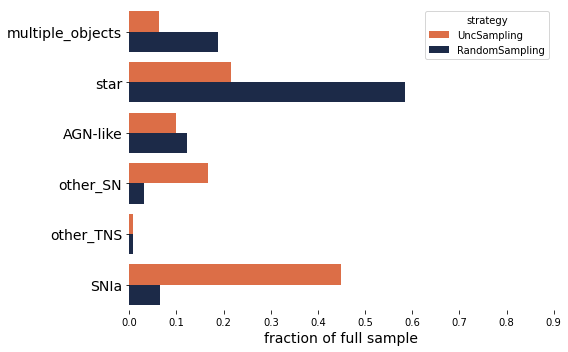

In [68]:
c = ['#F5622E', '#15284F']
types = ['multiple_objects', 'star', 'AGN-like', 'other_SN', 'other_TNS', 'SNIa']

f, ax = plt.subplots(figsize=(8, 5))

sns.set_palette('Spectral')
sns.barplot(x="sample fraction", y="type", data=df,
            hue='strategy', ci=None, palette=c)
ax.set(xlim=(0, 0.9), ylabel="")
ax.set_xlabel(xlabel="fraction of full sample", fontsize=14)
ax.set_yticklabels(types, fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
#plt.show()
plt.savefig('../../../../referee/plots/queried_classes.pdf')

# Photometrically classified Ia sample

In [3]:
res_photIa = {}

for strategy in ['RandomSampling', 'UncSampling']:
    res_photIa[strategy] = {}
    for name in big_class.keys():
        res_photIa[strategy][name] = []
    res_photIa[strategy]['tot'] = []
    
    flist = glob.glob('../../../../referee/' + strategy + '/class_prob/v*/class_prob_' + \
                      strategy + '_loop_299.csv')

    for name in flist:
        data = pd.read_csv(name)
        phot_Ia = data[data['prob_Ia']> 0.5]
        data_class = np.array([class_dict[item] for item in phot_Ia['type'].values])
        sntype, freq = np.unique(data_class, return_counts=True)

        for i in range(len(freq)):
            res_photIa[strategy][sntype[i]].append(freq[i]/data_class.shape[0])
        res_photIa[strategy]['tot'].append(phot_Ia.shape[0])

In [4]:
np.mean(res_photIa['RandomSampling']['other_SN'])

0.0805879104638081

In [5]:
for strategy in ['RandomSampling', 'UncSampling']:
    
    print('**** ' + strategy + ' ****')
    for key in res_photIa[strategy].keys():
        if key != 'tot':
            print(key, ' -- ', np.round(100* np.mean(res_photIa[strategy][key]), 2), 
                  ' -- ', np.round(100*np.std(res_photIa[strategy][key]),2))
    print('\n')

**** RandomSampling ****
multiple_object  --  0.54  --  0.37
star  --  1.02  --  0.68
AGN-like  --  4.27  --  5.88
other_SN  --  8.06  --  2.87
other_TNS  --  0.38  --  0.21
SNIa  --  86.82  --  7.99


**** UncSampling ****
multiple_object  --  0.55  --  0.32
star  --  1.63  --  0.63
AGN-like  --  0.7  --  0.5
other_SN  --  8.11  --  0.94
other_TNS  --  0.23  --  0.1
SNIa  --  88.8  --  1.69




In [6]:
for strategy in ['RandomSampling', 'UncSampling']:
    print(strategy,'  ', np.mean(res_photIa[strategy]['tot']), ' +/- ', 
          np.std(res_photIa[strategy]['tot']))
    print('\n')

RandomSampling    442.67  +/-  145.06026713059643


UncSampling    895.99  +/-  32.99348268976769




In [63]:
res = []

for strategy in ['RandomSampling', 'UncSampling']:
    for key in big_class.keys():
        mean = np.mean(res_photIa[strategy][key])
        std = np.std(res_photIa[strategy][key])
    
        line = [key, mean, std, strategy]
        res.append(line)
        
res2 = pd.DataFrame(data=res, columns=['type', 'perc', 'std', 'strategy'])

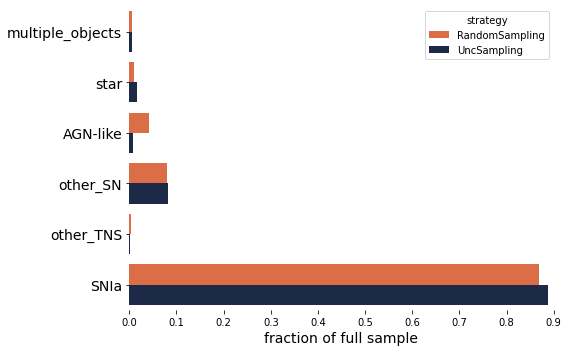

In [64]:
c = ['#F5622E', '#15284F']
types = ['multiple_objects', 'star', 'AGN-like', 'other_SN', 'other_TNS', 'SNIa']

f, ax = plt.subplots(figsize=(8, 5))

sns.set_palette('Spectral')
sns.barplot(x="perc", y="type", data=res2,
            hue='strategy', ci=None, palette=c)
ax.set(xlim=(0, 0.9), ylabel="")
ax.set_xlabel(xlabel="fraction of full sample", fontsize=14)
ax.set_yticklabels(types, fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
#plt.show()
plt.savefig('../../../../referee/plots/photom_classified.pdf')

In [65]:
res2

,type,perc,std,strategy
0,multiple_object,0.005260,0.003679,RandomSampling
1,star,0.010118,0.006865,RandomSampling
2,AGN-like,0.042728,0.058784,RandomSampling
3,other_SN,0.080608,0.028685,RandomSampling
4,other_TNS,0.003715,0.001960,RandomSampling
5,SNIa,0.868398,0.080010,RandomSampling
6,multiple_object,0.005475,0.003230,UncSampling
7,star,0.016326,0.006300,UncSampling
8,AGN-like,0.006957,0.004970,UncSampling
9,other_SN,0.081067,0.009358,UncSampling


# number of Ia in test sample for best model

In [11]:
fname = '../../../../referee/UncSampling/queries/queried_UncSampling_v68.dat'

In [14]:
data = pd.read_csv(fname, index_col=False, delim_whitespace=True)

In [16]:
sum(data['type'].values == 'Ia')

132

In [17]:
1600-132-5

1463